In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Create a DataFrame from the provided data
data = pd.DataFrame({
    'datetime': ['2008-09-14 13:03:10'],
    'latitude': [39.972909],
    'longitude': [116.418298],
    'what': [0.0],
    'altitude': [0.0],
    'days': [39705.543872],
    'segment': [0]
})

# Extract features (excluding 'segment') and target
X = data.drop(columns=['segment'])
y = data['segment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1  # Assuming binary classification (change to the number of classes if multi-class)
model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(torch.tensor(X_train.values, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train.values, dtype=torch.long))
    loss.backward()
    optimizer.step()

# Make predictions
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
    predicted_labels = torch.argmax(test_outputs, dim=1)

# Evaluate the model
accuracy = (predicted_labels == torch.tensor(y_test.values, dtype=torch.long)).sum().item() / len(y_test)
print("Accuracy:", accuracy)


In [15]:
import torch
import torch.nn as nn

# MLP 모델
class MLP(nn.Module):
    def __init__(self, input_shape, y_timestep, label_attribute, cell=256, num_of_hidden=2):
        super(MLP, self).__init__()
        
        self.input_shape = input_shape[-2] * input_shape[-1]
        self.y_timestep = y_timestep
        self.label_attribute = label_attribute
        self.output_shape = y_timestep * label_attribute
        self.cell = cell
        self.num_of_hidden = num_of_hidden

        self.fc_list= self.getSequential()
    
    def getSequential(self):
        final_list = []
        final_list.append(nn.Linear(self.input_shape, self.cell, dtype=torch.double))
        final_list.append(nn.LeakyReLU(negative_slope=0.1))

        for _ in range(self.num_of_hidden):
            final_list.append(nn.Linear(self.cell, self.cell, dtype=torch.double))
            final_list.append(nn.LeakyReLU(negative_slope=0.1))

        final_list.append(nn.Linear(self.cell, self.output_shape, dtype=torch.double))
        # final_list.append(nn.LeakyReLU(negative_slope=0.1))
        return nn.Sequential(*final_list)

    def forward(self, x):
        batch = torch._shape_as_tensor(x)[0]
        mini_batch = torch._shape_as_tensor(x)[1]
        time_step = torch._shape_as_tensor(x)[2]
        attribute = torch._shape_as_tensor(x)[3]

        in_shape_new = [-1] + [time_step * attribute]
        x = torch.reshape(x, in_shape_new)

        x  = self.fc_list(x)
        
        out_shape_new = [batch] + [-1] + [self.y_timestep] + [self.label_attribute]
        out = torch.reshape(x, out_shape_new)
        return out

In [18]:
import os
import numpy as np
import datetime

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from torch_segment_dataset import SegmentDataset

def metricDist(y_true, y_pred):
    row = (y_pred[:,:,:,0] - y_true[:,:,:,0])**2
    col = (y_pred[:,:,:,1] - y_true[:,:,:,1])**2
    return torch.mean(row + col) ** 0.5

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"use_cuda: {use_cuda}, device: {device}")

data_dir = "data/geolife/Data/"

user_list = ["068", "003", "004"]
min_length = 6
time_delta = 60
length = min_length * time_delta

y_timestep = min_length * 2
x_attribute = 15
label_attribute = 2
sample_s = 5
sample_q = 5
replace = False
model_type = 'mlp'
batch_size = 2

# Dataset
training_data    = SegmentDataset(model_type, data_dir, user_list, device, time_delta, y_timestep, length, label_attribute, sample_s, sample_q)
train_dataloader = DataLoader(training_data, batch_size, shuffle=False)

# Model 훈련 진행
model = MLP(input_shape=[length, x_attribute], y_timestep = y_timestep, label_attribute=label_attribute, num_of_hidden=3, cell=64)

model = model.to(torch.double)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(10):
    model.train()
    for train_idx, train_data in enumerate(train_dataloader, 0):
        task_X, task_y = train_data
        optimizer.zero_grad()
        output = model(task_X)
        loss = criterion(output, task_y)
        loss.backward()
        optimizer.step()

# 예측
with torch.no_grad():
    model.eval()
    predicted = model(task_X)
    loss = metricDist(task_y, predicted)
    print("target latitude, longitude:", task_y)
    print("Predicted latitude, longitude:", predicted)
    print(f'loss: {loss}')


use_cuda: True, device: cuda:0
target latitude, longitude: tensor([[[[5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.7000e+01, 1.0100e+02],
          [5.8000e+01, 1.0100e+02]],

         [[1.5000e+01, 6.8000e+01],
          [1.5000e+01, 6.8000e+01],
          [1.5000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.8000e+01],
          [1.6000e+01, 6.9000e+01],
          [1.6000e+01, 6.9000e+01]],

         [[4.7100e+02, 8.1100e+02],
          [4.6900e+02, 8.1300e+02],
 

In [19]:
import pandas as pd
from torch_mlp import MLP
from torch_segment_dataset import SegmentDataset

writer_dir_name = 'data/geolife/runs'
log_dir_name = '[segment_mlp]_20240304-233803'
log_folder = writer_dir_name + '/' + log_dir_name
best_model_path = log_folder + '/best_model.pth'
# best_model_path = log_folder + '/best_train_model.pth'

config_df = pd.read_csv(log_folder + '/configuration.csv')
config_df.head()

,device,model_type,label_attribute,user_list_file,sample_s,sample_q,epoch,patience,x_attribute,time_delta,y_timestep,length,train_list,val_list,test_list,train_columns
0,cuda:0,mlp,2,grid_user_list.csv,5,5,100000,5,15,10,6,60,['068'],['068'],['068'],"['days', 'x', 'y', 'year', 'month', 'week', 'w..."


In [20]:
data_dir = "data/geolife/Data/"
label_attribute = 2

sample_s = config_df['sample_s'][0]
sample_q = config_df['sample_q'][0]

args_epoch = config_df['epoch'][0]
args_patience = config_df['patience'][0]

gap_min = 12 # 1 min
gap = gap_min

hidden_layer = 3
cell = 256

# loss_method = 'mse'
loss_method = 'cross'

# day = config_df['day'][0]
# week = config_df['week'][0]
x_attribute = config_df['x_attribute'][0]
y_timestep = config_df['y_timestep'][0] 
length = config_df['length'][0]
time_delta = 10

train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['test_list'][0]

train_size = 0.4
validation_size = 0.1
batch_size = 1 # each user

data_type = 'segment'
model_type = 'mlp'
# model_type = 'time-hetnet'

device = 'cpu'#config_df['device'][0]

## Test Phase
is_train = False

print(f"y_timestep: {y_timestep}, length: {length}")
print(f"data_type: {data_type}, model_type: {model_type}")

y_timestep: 6, length: 60
data_type: segment, model_type: mlp


In [4]:
# TensorBoard 설정
import ast
from torch_time_het import TimeHetNet

import torch
from torch.utils.data import DataLoader
from torch_geolife_dateset import GeoLifeDataSet
from data.geolife.convert_minmax_location import LocationPreprocessor
import random

from torch_mlp import MLP
from torch_segment_dataset import SegmentDataset

data_dir = "data/geolife/Data/"


train_list = config_df['train_list'][0]
validation_list = config_df['val_list'][0]
test_list = config_df['val_list'][0]#, '078']

test_list = ['068']#['014', '037', '067', '036', '050', '034']
# test_list = ['068', '038']#, '039']#, '067']

print(f"train_list:      {train_list}")
print(f"validation_list: {validation_list}")
print(f"test_list:       {test_list}")

if data_type == 'segment':
    ### TimeHetnet
    # Multi user
    training_data           = SegmentDataset(model_type, data_dir, train_list, device, time_delta, y_timestep, length, label_attribute, sample_s, sample_q)
    validation_data         = SegmentDataset(model_type, data_dir, validation_list, device, time_delta, y_timestep, length, label_attribute, sample_s, sample_q)
    test_data               = SegmentDataset(model_type, data_dir, test_list, device, time_delta, y_timestep, length, label_attribute, sample_s, sample_q)

    train_dataloader        = DataLoader(training_data, batch_size, shuffle=False)
    validation_dataloader   = DataLoader(validation_data, batch_size, shuffle=False)
    test_dataloader         = DataLoader(test_data, batch_size, shuffle=False)

    if model_type == 'time-hetnet':
        best_model = TimeHetNet(dims_inf = ast.literal_eval("[32,32,32]"),
                            dims_pred = ast.literal_eval("[32,32,32]"), 
                            activation="relu", 
                            time=100,
                            batchnorm=False, 
                            block = str("gru,conv,conv,gru").split(","),
                            output_shape=[y_timestep, 2],
                            length=length)
    else:
        best_model = MLP(input_shape=[length, x_attribute], y_timestep = y_timestep, loss_fn=loss_method, label_attribute=label_attribute, cell=cell, hidden_layer=hidden_layer)

    best_model.load_state_dict(torch.load(best_model_path))

else:
    ### TimeHetnet
    # Multi user
    training_data   = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep, gap, label_attribute)
    validation_data = GeoLifeDataSet(data_dir, validation_list, sample_s, sample_q, length, y_timestep, gap, label_attribute)
    test_data       = GeoLifeDataSet(data_dir, test_list, sample_s, sample_q, length, y_timestep, gap, label_attribute)

    # single user
    # training_data   = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep, gap, label_attribute, mode='train')
    # validation_data = GeoLifeDataSet(data_dir, validation_list, sample_s, sample_q, length, y_timestep, gap, label_attribute, mode='valid')
    # test_data       = GeoLifeDataSet(data_dir, test_list, sample_s, sample_q, length, y_timestep, gap, label_attribute, mode='valid')


    train_dataloader      = DataLoader(training_data, batch_size, shuffle=False)
    validation_dataloader = DataLoader(validation_data, batch_size, shuffle=False)
    test_dataloader       = DataLoader(test_data, batch_size, shuffle=False)

    best_model = TimeHetNet(dims_inf = ast.literal_eval("[32,32,32]"),
                            dims_pred = ast.literal_eval("[32,32,32]"), 
                            activation="relu", 
                            time=100,
                            batchnorm=False, 
                            block = str("gru,conv,conv,gru").split(","),
                            output_shape=[y_timestep, 2],
                            length=length)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.to(device=device)


train_list:      ['068']
validation_list: ['068']
test_list:       ['068']


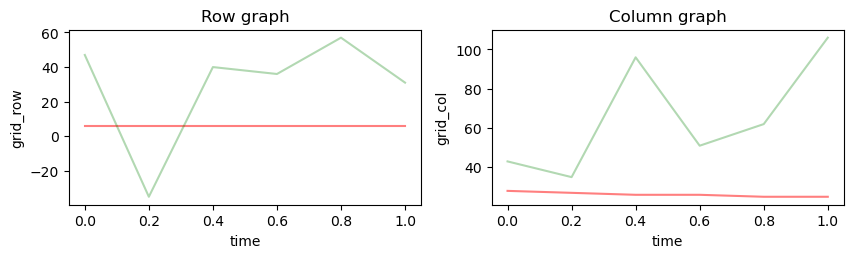

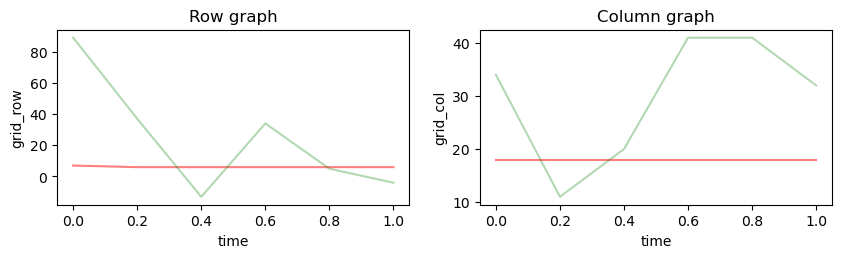

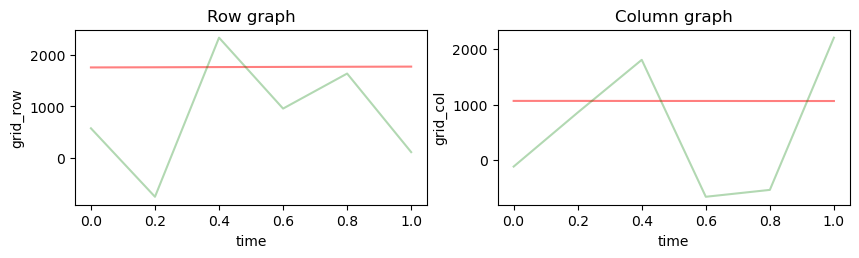

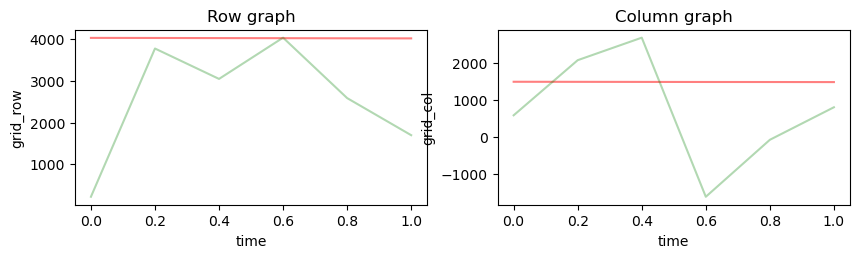

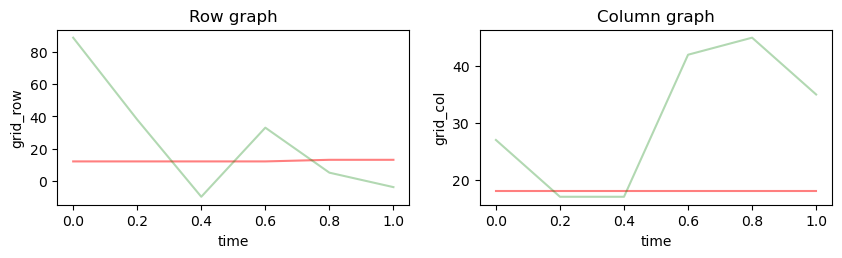

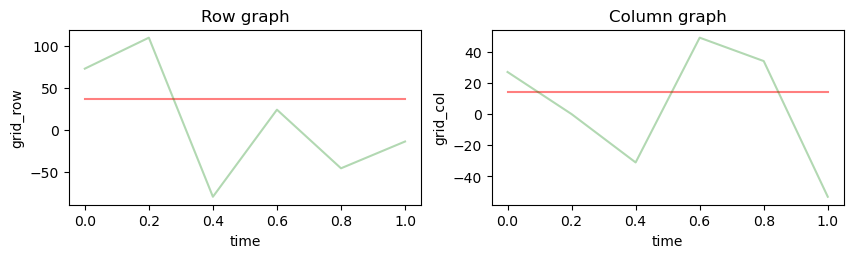

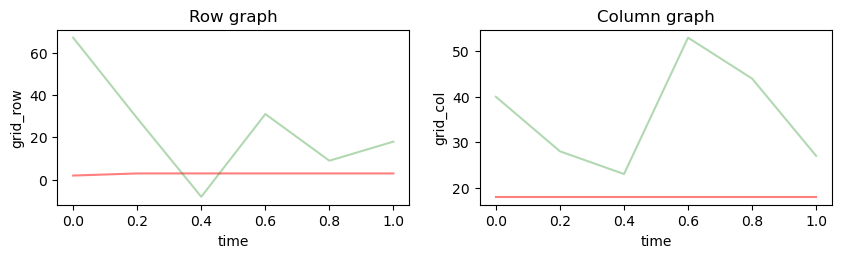

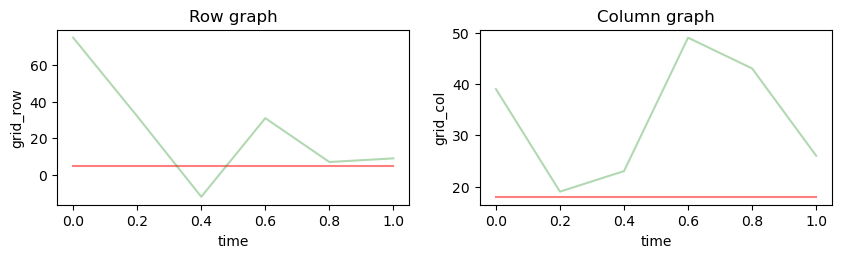

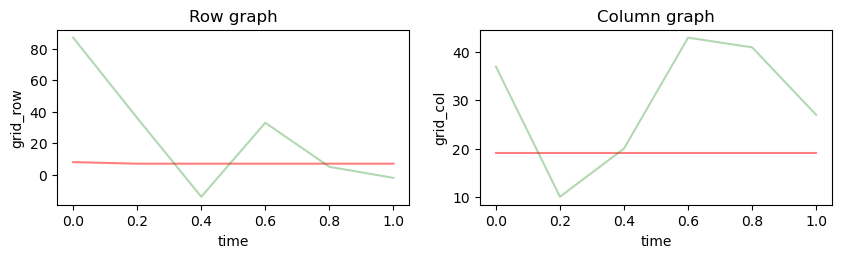

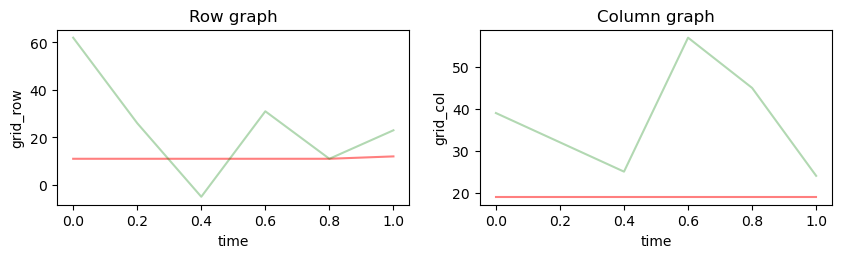

In [6]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class_probs = []
class_label = []
que_x_list = []

with torch.no_grad():
    for idx, test_data in enumerate(test_dataloader, 0):
        test_X, test_y = test_data

        class_probs = []
        class_label = []
        que_x_list = []

        if model_type == 'time-hetnet':
            que_x, _, _ = test_X
            output = best_model(test_X)
            que_x_list.append(que_x[:, :, -y_timestep:, 0])
        else:
            output = best_model(test_X)
            que_x_list.append(test_X[:, :, -y_timestep:, 0])

        class_probs.append(output.type(torch.int64))
        class_label.append(test_y)
        
        test_probs = torch.cat(class_probs).to(device)
        test_label = torch.cat(class_label).to(device)
        test_que_x = torch.cat(que_x_list).to(device)

        # print(test_probs.shape)
        # print(test_label.shape)
        # print(test_que_x.shape)

        for user_idx in range(test_label.shape[0]):
            for test_idx in range(test_label.shape[1]):
                df = pd.DataFrame(data=test_que_x[user_idx][0], columns=['Time'])
                df_norm = MinMaxScaler().fit_transform(df)

                plt.figure(figsize=(10, 5))
                plt.subplot(2, 2, 1)
                plt.title('Row graph')
                # plt.scatter(df_norm, test_label[user_idx][test_idx][:, 0] , color='r', alpha=0.5)
                # plt.scatter(df_norm, test_probs[user_idx][test_idx][:, 0], color='g', alpha=0.3)
                plt.plot(df_norm, test_label[user_idx][test_idx][:, 0] , color='r', alpha=0.5)
                plt.plot(df_norm, test_probs[user_idx][test_idx][:, 0], color='g', alpha=0.3)
                plt.xlabel('time')
                plt.ylabel('grid_row')
                
                # fig_col = plt.figure(figsize=(5, 3))
                plt.subplot(2, 2, 2)
                plt.title('Column graph')
                # plt.scatter(df_norm, test_label[user_idx][test_idx][:, 1] , color='r', alpha=0.5)
                # plt.scatter(df_norm, test_probs[user_idx][test_idx][:, 1], color='g', alpha=0.3)
                plt.plot(df_norm, test_label[user_idx][test_idx][:, 1] , color='r', alpha=0.5)
                plt.plot(df_norm, test_probs[user_idx][test_idx][:, 1], color='g', alpha=0.3)
                plt.xlabel('time')
                plt.ylabel('grid_col')
                # plt.show() 


In [ ]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

for idx in range(test_label.shape[0]):
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)

    fig_row = plt.figure(figsize=(9, 6))
    ax_row = fig_row.add_subplot(111)
    ax_row.plot(df_norm, test_label[idx][0][:, 0] , color='r', alpha=0.5)
    ax_row.plot(df_norm, test_probs[idx][0][:, 0], color='g', alpha=0.3)
    ax_row.set_xlabel('time')
    ax_row.set_ylabel('grid_row')
    
    ax_col = fig_row.add_subplot(222)
    ax_col.plot(df_norm, test_label[idx][0][:, 1] , color='r', alpha=0.5)
    ax_col.plot(df_norm, test_probs[idx][0][:, 1], color='g', alpha=0.3)
    ax_col.set_xlabel('time')
    ax_col.set_ylabel('grid_col')


In [ ]:
# https://jimmy-ai.tistory.com/30
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x, y, z, color = 'r', alpha = 0.5)
# ax.scatter(x, z, y, color = 'g', alpha = 0.5) # y와 z축 swap

for idx in range(test_label.shape[0]):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=10, azim=-50)
    df = pd.DataFrame(data=test_que_x[idx][0], columns=['Time'])
    df_norm = MinMaxScaler().fit_transform(df)
    ax.scatter(test_label[idx][0][:, 0], test_label[idx][0][:, 1], df_norm,
               color='r', alpha=0.5)
    ax.scatter(test_probs[idx][0][:, 0], test_probs[idx][0][:, 1], df_norm, 
               color='g', alpha=0.5)
    print(df_norm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('time')

In [ ]:
# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.functional as F

from torch import optim

import pandas as pd

class My_Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=None, name=None):
        super(My_Linear, self).__init__()
        self.Linear = nn.Linear(in_features, out_features, bias, device)
        self.name = name
    
    def forward(self, x):
        # print(f"My_Linear - X.shape: {x.shape}, name: {self.name}")
        x = self.Linear(x)
        return x

In [ ]:
df = pd.read_csv('data/geolife/Data/000/csv/000.csv')
df.head(1)
df_test = df.iloc[:, :-2].copy()
df_test.head(1)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [ ]:
X = ['latitude', 'longitude', 'altitude', 'days']
df_x = df_test[X].head(10).copy()
df_x = df_to_tensor(df_x)
print(df_x)
df_x = df_x.unsqueeze(axis=-1)
print(df_x)
df_x = df_x.sum(axis=2)
print(df_x)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_test, train_size=0.7, random_state=123)

X = ['latitude', 'longitude', 'altitude', 'days']
y = ['latitude', 'longitude']

row = 10
train_set = train_set.iloc[:row, :].copy()

train_X = df_to_tensor(train_set[X])
train_y = df_to_tensor(train_set[y])

model = My_Linear(4, 2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
out_list = []
loss_train = 0.0
epochs = 10
for epoch in range(epochs):
    for input in train_X:
        outputs = model(input)
        print(outputs)
        loss = loss_fn(outputs, train_y)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    
    print(f"epoch:{epoch}, loss:{loss_train}")

In [ ]:
train_y